[Keras OCR](https://keras.io/examples/vision/captcha_ocr/)

In [ ]:
!pip install tf2onnx
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
tensorflow 2.17.1 requires keras>=3.2.0, but you have keras 2.13.1 which is incompatible.


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !curl -LO /content/drive/MyDrive/OCR_Dates_Dataset.zip
!unzip -qq drive/MyDrive/OCR_Dates_Dataset.zip

In [ ]:
# Path to the data directory
data_dir = Path("/content/OCR_Dates")
# data_dir
# Get list of all the images
sorted(list(map(str, list(data_dir.glob("*.jpg")))))
# images

['/content/OCR_Dates/0.jpg',
 '/content/OCR_Dates/1.jpg',
 '/content/OCR_Dates/10.jpg',
 '/content/OCR_Dates/100.jpg',
 '/content/OCR_Dates/1000.jpg',
 '/content/OCR_Dates/10000.jpg',
 '/content/OCR_Dates/10001.jpg',
 '/content/OCR_Dates/10002.jpg',
 '/content/OCR_Dates/10003.jpg',
 '/content/OCR_Dates/10004.jpg',
 '/content/OCR_Dates/10005.jpg',
 '/content/OCR_Dates/10006.jpg',
 '/content/OCR_Dates/10007.jpg',
 '/content/OCR_Dates/10008.jpg',
 '/content/OCR_Dates/10009.jpg',
 '/content/OCR_Dates/1001.jpg',
 '/content/OCR_Dates/10010.jpg',
 '/content/OCR_Dates/10011.jpg',
 '/content/OCR_Dates/10012.jpg',
 '/content/OCR_Dates/10013.jpg',
 '/content/OCR_Dates/10014.jpg',
 '/content/OCR_Dates/10015.jpg',
 '/content/OCR_Dates/10016.jpg',
 '/content/OCR_Dates/10017.jpg',
 '/content/OCR_Dates/10018.jpg',
 '/content/OCR_Dates/10019.jpg',
 '/content/OCR_Dates/1002.jpg',
 '/content/OCR_Dates/10020.jpg',
 '/content/OCR_Dates/10021.jpg',
 '/content/OCR_Dates/10022.jpg',
 '/content/OCR_Dates/10023

In [ ]:
label = []
text = sorted(list(map(str, list(data_dir.glob("*.txt")))))
for file in text:
  with open(file) as f:
    data = f.read()
    label.append(data)
print(label[:10])

['١٩٩٩/٠٧/١٥', '١٩٨٢/٠٥/٠٨', '١٩٨٦/٠٦/٠٦', '٢٠١١/١٢/٠١', '٢٠١٩/١١/٠٠', '١٩٩٤/٠٥/١٨', '١٩٧٥/٠٦/١٢', '٢٠٠٣/١٢/٠٣', '١٩٨٧/٠٨/٢٢', '٢٠١٩/٠٣/١٥']


In [ ]:
# Path to the data directory
data_dir = Path("/content/OCR_Dates")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = []
text = sorted(list(map(str, list(data_dir.glob("*.txt")))))
for file in text:
  with open(file) as f:
    labels.append(f.read())

# labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# # Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# # Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  19985
Number of labels found:  19980
Number of unique characters:  11
Characters present:  ['/', '٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩']


In [ ]:
len(images), len(text), max_length

(19985, 19980, 10)

In [ ]:
for i in images:
  extract = i.split('/')[-1].split('.')[0]
  t = f'/content/OCR_Dates/{extract}.txt'
  # print(t)
  if t in text:
    # print(t)
    continue
  else:
    images.remove(i)


In [ ]:
len(images), len(text)

(19980, 19980)

## Preprocessing

- StringLookup: A preprocessing layer which maps string features to integer indices.



In [20]:
# Define Arabic and English numerals as strings
arabic_numerals = ['/', '٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩']
english_numerals = ["/", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

# Create StringLookup layer to map Arabic to indices
char_to_num = layers.StringLookup(vocabulary=arabic_numerals, oov_token="", mask_token=None)

# Create a StringLookup layer with an invert option to map indices back to English numerals
num_to_char = layers.StringLookup(vocabulary=english_numerals, invert=True, mask_token=None)

In [ ]:
char_to_num.get_vocabulary()

['', '/', '٠', '١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩']

In [ ]:
print(num_to_char)

<StringLookup name=string_lookup_1, built=False>


In [ ]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[:train_samples], labels[:train_samples]
    x_valid, y_valid = images[train_samples:], labels[train_samples:]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

In [ ]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

## Create Dataset objects


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Visualize the data

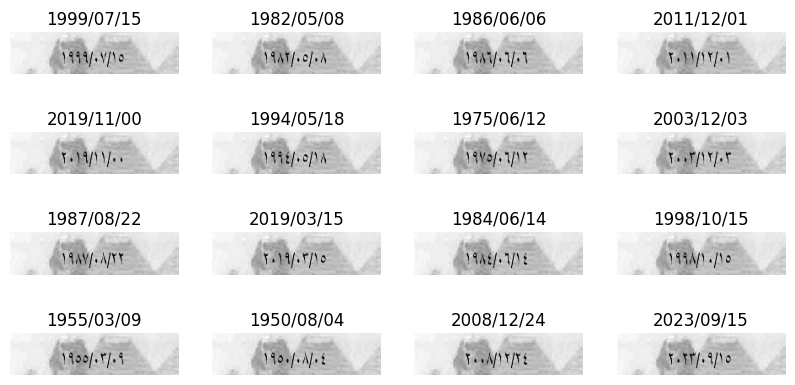

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Model

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [ ]:
def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 200, 50, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 200, 50, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 100, 25, 32)    │              0 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2 (Conv2D)            │ (None, 100, 25, 64)    │         18,496 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 50, 12, 64)     │              0 │ Conv2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 50, 768)        │              0 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 50, 64)         │         49,216 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 50, 64)         │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50, 256)        │        197,632 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 50, 128)        │        164,352 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 50, 13)         │          1,677 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (CTCLayer)       │ (None, 50, 13)         │              0 │ label[0][0],           │
│                           │                        │                │ dense2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 431,693 (1.65 MB)

 Trainable params: 431,693 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
tf.random.set_seed(42)

In [ ]:
epochs = 40
early_stopping_patience = 5
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],

)

Epoch 1/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 534s 462ms/step - loss: 317.6409 - val_loss: 159.2879
Epoch 2/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 541s 443ms/step - loss: 147.5410 - val_loss: 112.2135
Epoch 3/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 482s 429ms/step - loss: 100.1916 - val_loss: 60.0062
Epoch 4/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 479s 426ms/step - loss: 58.2022 - val_loss: 36.3055
Epoch 5/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 501s 425ms/step - loss: 34.0890 - val_loss: 9.9861
Epoch 6/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 497s 421ms/step - loss: 9.4946 - val_loss: 0.8057
Epoch 7/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 504s 422ms/step - loss: 2.2904 - val_loss: 0.2136
Epoch 8/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 471s 419ms/step - loss: 1.8517 - val_loss: 0.2001
Epoch 9/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 505s 422ms/step - loss: 1.9207 - val_loss: 0.1405
Epoch 10/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 498s 418ms/step - loss: 1.4367 - val_loss: 0.0593


In [ ]:
# Get the actual input layer of the original model
input_layer = model.inputs[0]  # Assuming your model has a single input

# Get the prediction model by extracting layers till the output layer
prediction_model = tf.keras.models.Model(
    inputs=input_layer, outputs=model.get_layer(name="dense2").output
)
prediction_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 200, 50, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 200, 50, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 100, 25, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 100, 25, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 50, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 50, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 50, 64)              │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 50, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 50, 13)              │           1,677 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 431,693 (1.65 MB)

 Trainable params: 431,693 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tf2onnx
import onnx

# Convert to ONNX
spec = (
    tf.TensorSpec((None, 200, 50, 1), tf.float32, name="image"),
    tf.TensorSpec((None, 10), tf.float32, name="dense2"),  # Replace with actual details
)

# model = tf.keras.models.load_model('model..keras')
# Use from_function for tf functions
onnx_model, _ = tf2onnx.convert.from_keras(model, spec, opset=13)
onnx.save(onnx_model, "./model.onnx")

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
ERROR:tf2onnx.tfonnx:Tensorflow op [ocr_model_v1_1/bidirectional_1/forward_lstm_1/stateless_dropout/stateless_random_uniform/StatelessRandomUniformV2: StatelessRandomUniformV2] is not supported
ERROR:tf2onnx.tfonnx:Tensorflow op [ocr_model_v1_1/bidirectional_1/forward_lstm_1/CudnnRNNV3: CudnnRNNV3] is not supported
ERROR:tf2onnx.tfonnx:Tensorflow op [ocr_model_v1_1/bidirectional_1/backward_lstm_1/stateless_dropout/stateless_random_uniform/StatelessRandomUniformV2: StatelessRandomUniformV2] is not supported
ERROR:tf2onnx.tfonnx:Tensorflow op [ocr_model_v1_1/bidirectional_1/backward_lstm_1/CudnnRNNV3: CudnnRNNV3] is not supported


In [ ]:
# Convert to ONNX
spec = (
    tf.TensorSpec((None, 200, 50, 1), tf.float32, name="image"),
)
onnx_model_pred, _ = tf2onnx.convert.from_keras(prediction_model, spec)
onnx.save(onnx_model_pred, "./pred_model.onnx")

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
ERROR:tf2onnx.tfonnx:Tensorflow op [functional_1/bidirectional_1/forward_lstm_1/stateless_dropout/stateless_random_uniform/StatelessRandomUniformV2: StatelessRandomUniformV2] is not supported
ERROR:tf2onnx.tfonnx:Tensorflow op [functional_1/bidirectional_1/forward_lstm_1/CudnnRNNV3: CudnnRNNV3] is not supported
ERROR:tf2onnx.tfonnx:Tensorflow op [functional_1/bidirectional_1/backward_lstm_1/stateless_dropout/stateless_random_uniform/StatelessRandomUniformV2: StatelessRandomUniformV2] is not supported
ERROR:tf2onnx.tfonnx:Tensorflow op [functional_1/bidirectional_1/backward_lstm_1/CudnnRNNV3: CudnnRNNV3] is not supported
ERROR:tf

In [4]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


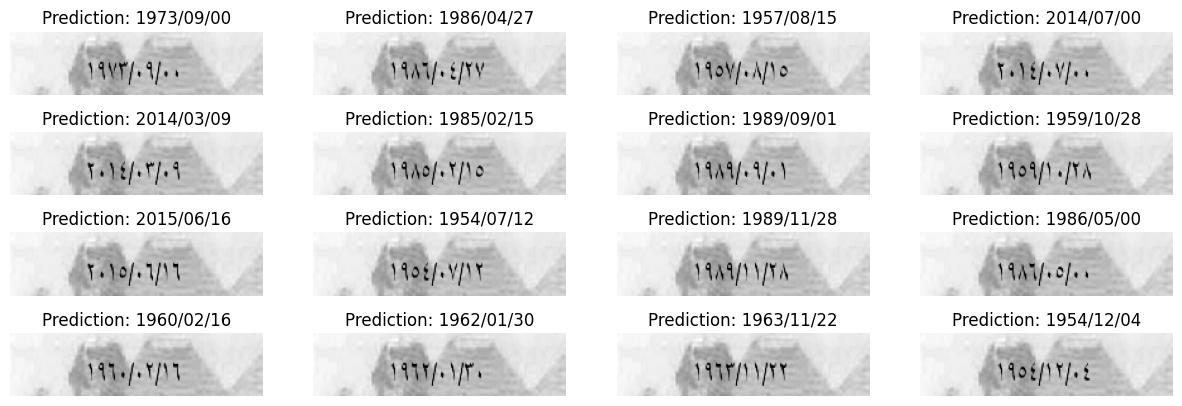

In [ ]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [ ]:
model.save('model.h5')
prediction_model.save('pred_model.h5')

In [ ]:
import tf2onnx
import onnx
import tensorflow as tf

# Convert to ONNX
spec = (
    tf.TensorSpec((None, 200, 50, 1), tf.float32, name="image"),
)

model = tf.keras.models.load_model('pred_model.h5')
# model.summary()
onnx_model, _ = tf2onnx.convert.from_keras(model, spec)
# print(onnx_model)
onnx.save(onnx_model, "pred_model.onnx")
# with open('pred_model.onnx', 'wb') as f:
#     f.write(onnx_model.SerializeToString())